In [251]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [252]:
train = pd.read_csv('train_final_best_2.csv')
test = pd.read_csv('test_final_best_2.csv')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Elton John*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [253]:
#...Distribution of continuous variables...#

In [254]:
#...Distribution of categorical variables...#

In [255]:
#...Association of the response with the predictors...#

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [256]:
#...Code with comments...#

### Data preparation
*By Sabrina Kozarovitsky*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Based on personal experience, I believe that certain hours and days may have more demand than others which may lead to higher prices. The data currently in date_hour is in a string format. In order to better use the day and time of the ride as a predictor in our model, it is important to convert date_hour into a datetime format. Additionaly, to see if hour and day may affect demand and in turn price, we can extract hour and day into separate columns to use as separate predictors. This code preparation will be useful in EDA.

In [257]:
type(train['date_hour'][0])

str

In [258]:
train['timestamp'] = train.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))
test['timestamp'] = test.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))

#Find hour of each trip
train['hour'] = train['timestamp'].dt.strftime('%H')
test['hour'] = test['timestamp'].dt.strftime('%H')

#Find date of each trip
train['date'] = train['timestamp'].dt.strftime('%Y-%m-%d') 
test['date'] = test['timestamp'].dt.strftime('%Y-%m-%d') 

#Find day name of each trip
train['day'] = train['timestamp'].dt.day_name()
test['day'] = test['timestamp'].dt.day_name()

# drop redundant fields 
train = train.drop('timestamp', axis=1)
test = test.drop('timestamp', axis=1)

In [259]:
#converting hour to int to ensure that EDA graphs are in order of time
train['hour']=train['hour'].astype('int')

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Cindy: General EDA

Text(23.958505555555554, 0.5, 'Price')

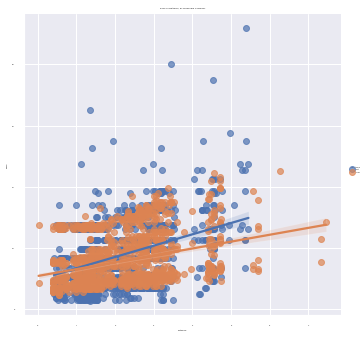

In [260]:
# seeing whether lyft vs uber is a good predictor of price
sns.lmplot(data = train, x = 'distance', y = 'price', hue = 'cab_type', scatter_kws={'alpha':0.7})
plt.title('Price vs Distance, by Rideshare Company')
plt.xlabel('Distance')
plt.ylabel('Price')


Text(0, 0.5, 'Price')

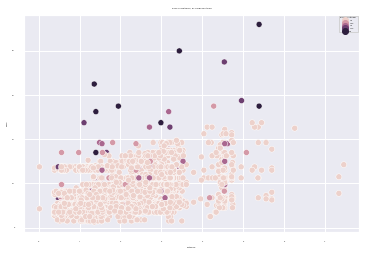

In [261]:
# investigating surge multiplier, although it was left out of further analysis since we don't know the surge multiplier value when predicting prices in real life
a = sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'surge_multiplier')
plt.title('Price vs Distance, by Surge Multiplier')
plt.xlabel('Distance')
plt.ylabel('Price')

### Cindy: Weather EDA

<AxesSubplot:xlabel='wind_d_strength', ylabel='price'>

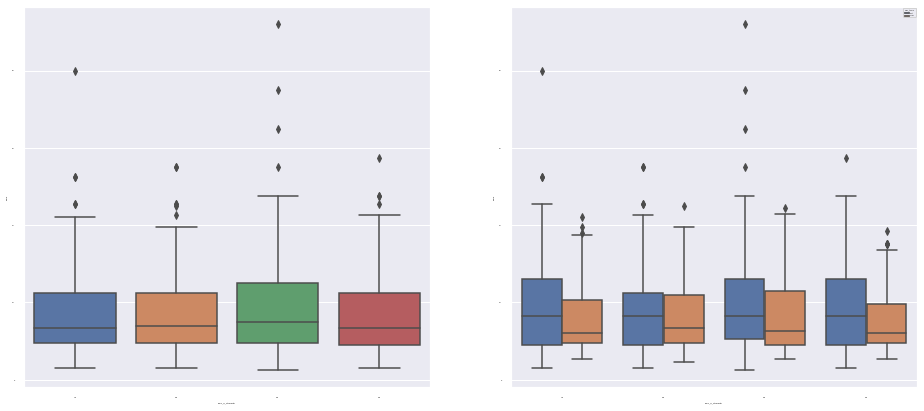

In [262]:
# wind 

# getting 25, 50, and 75th quartile amounts for wind
wd25, wd50, wd75 = train['wind'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the wind was based on its relationship to the quartiles
train.loc[train['wind'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind'] < wd50) & (train['wind'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind'] < wd75) & (train['wind'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind'] >= wd75, 'wind_d_strength'] = 4
# graphing how wind strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price')
sns.boxplot(ax=ax[1], data = train, x = 'wind_d_strength', y = 'price', hue = 'cab_type')

<AxesSubplot:xlabel='pressure_d_strength', ylabel='price'>

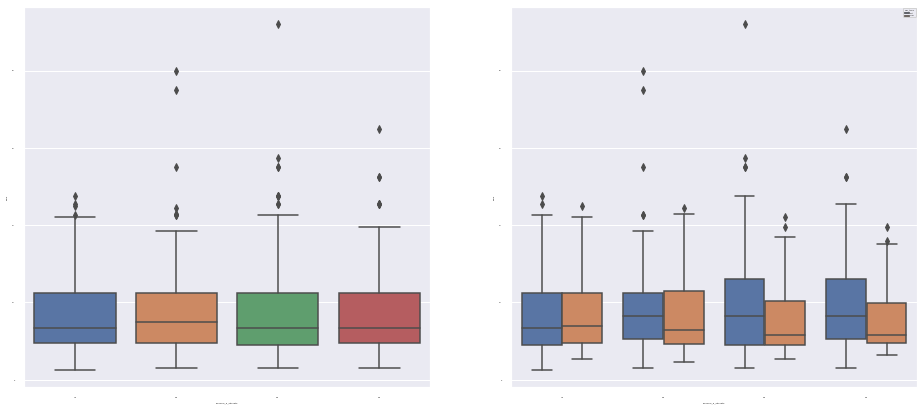

In [263]:
# pressure 

# getting 25, 50, and 75th quartile amounts for pressure
pd25, pd50, pd75 = train['pressure'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the pressure was based on its relationship to the quartiles
train.loc[train['pressure'] < pd25, 'pressure_d_strength'] = 1
train.loc[((train['pressure'] < pd50) & (train['pressure'] >= pd25)), 'pressure_d_strength'] = 2
train.loc[((train['pressure'] < pd75) & (train['pressure'] >= pd50)), 'pressure_d_strength'] = 3
train.loc[train['pressure'] >= pd75, 'pressure_d_strength'] = 4
# graphing how pressure strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'pressure_d_strength', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'pressure_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_d_strength', ylabel='price'>

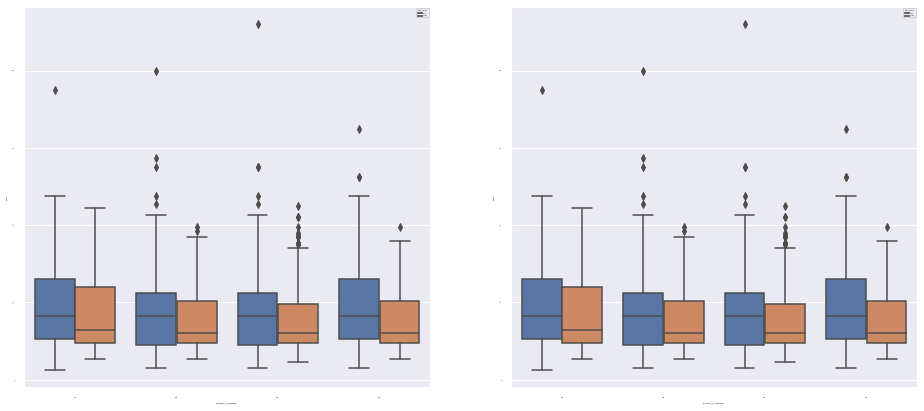

In [264]:
# humidity 

# getting 25, 50, and 75th quartile amounts for pressure
hd25, hd50, hd75 = train['humidity'].quantile([0.25, 0.5, 0.75])
#  # creating separate column with values indicating how severe the humidity was based on its relationship to the quartiles
train.loc[train['humidity'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity'] < hd50) & (train['humidity'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity'] >= hd75, 'humidity_d_strength'] = 4
# graphing how humidity strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_strength_3', ylabel='price'>

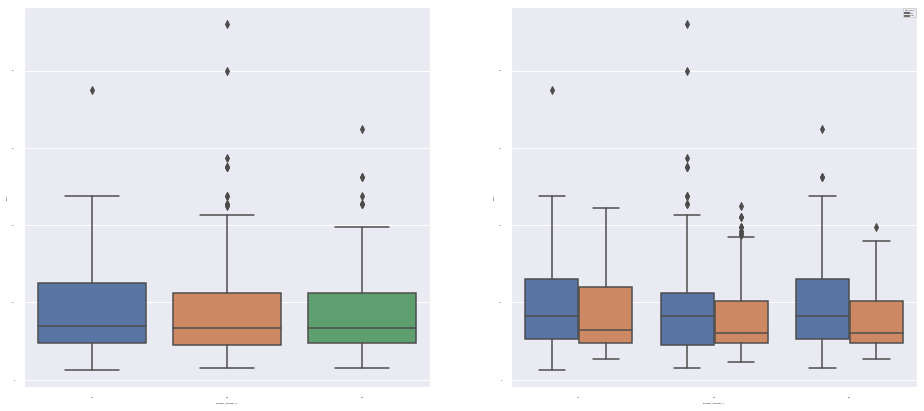

In [265]:
# trying to bin humidity into 3 instead of 4 to see if there's a stronger relationship...
train.loc[train['humidity'] < hd25, 'humidity_strength_3'] = 1
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd25)), 'humidity_strength_3'] = 2
train.loc[train['humidity'] >= hd75, 'humidity_strength_3'] = 3
#plotting it again
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_strength_3', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_strength_3', y = 'price', hue = 'cab_type')
# there was no real difference 

[Text(8.200000000000003, 0.5, 'Price')]

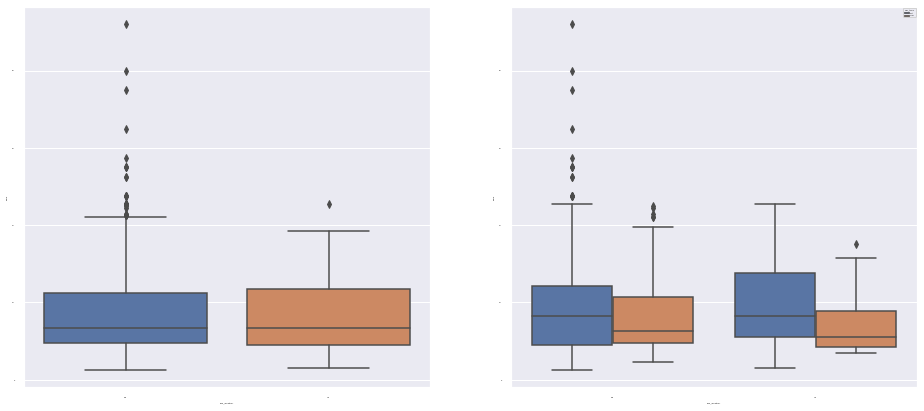

In [266]:
# instead of using humidity, pressure, and wind on its own, create another indicator value for "bad" and "good" weather
# defined bad weather as rides where wind and pressure strength were in the top 25th percentile 
train.loc[(train['wind_d_strength'] == 4) & (train['pressure_d_strength'] == 4), 'bad_weather'] = 1
train.fillna(0, inplace = True)

fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'bad_weather', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'bad_weather', y = 'price', hue = 'cab_type')
#graph price based on whether it was good or bad weather

a.set(title = 'Prices during Good and Bad Weather')
a.set(xlabel = 'Weather')
a.set(ylabel = 'Price')

In [71]:
# investigate how bad/good weather related with distance
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'bad_weather')
plt.title('Price vs Distance')
plt.xlabel('Distance')
plt.ylabel('Price')

ValueError: Could not interpret value `bad_weather` for parameter `hue`

### Cindy: Location EDA

In [72]:
# getting a dataframe containing the # of rides to/from each location
locationdf = pd.DataFrame(train['location'].value_counts()).reset_index()
locationdf.columns = ['location', 'count']
locationdf

,location,count
0,Haymarket Square,262
1,North Station,225
2,Northeastern University,221
3,South Station,208
4,Boston University,205
5,Theatre District,204
6,Beacon Hill,204
7,Financial District,202
8,Fenway,196
9,North End,188


[Text(0.5, 0, 'Location')]

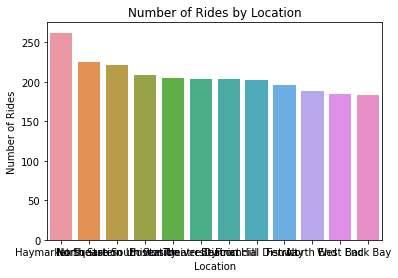

In [73]:
# it's roughly around the same area, but going to graph it to vizualize it better
a = sns.barplot(data = locationdf, x = 'location', y = 'count')
a.set(title='Number of Rides by Location')
a.set(ylabel='Number of Rides')
a.set(xlabel='Location')

In [74]:
locationprice = pd.DataFrame(train.groupby('location').agg('mean')['price']).reset_index()
locationprice

,location,price
0,Back Bay,17.467213
1,Beacon Hill,15.284314
2,Boston University,18.987805
3,Fenway,18.346939
4,Financial District,18.168317
5,Haymarket Square,14.024809
6,North End,15.781915
7,North Station,16.695556
8,Northeastern University,17.834842
9,South Station,16.192308


[Text(0.5, 0, 'Location')]

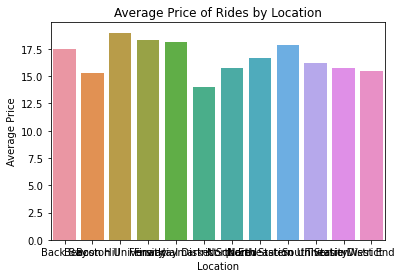

In [75]:
# vizualize avg price by location 
a = sns.barplot(data = locationprice, x = 'location', y = 'price')
a.set(title='Average Price of Rides by Location')
a.set(ylabel='Average Price')
a.set(xlabel='Location')

### Sabrina: Time EDA

<AxesSubplot:xlabel='hour', ylabel='price'>

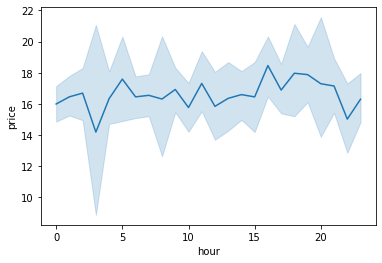

In [76]:
#Graphing to see average price by hour
sns.lineplot(x='hour', y='price', data=train)
#Average stays roughly between 14 and 18 dollars but is variable so we should consider different ways of binning hour

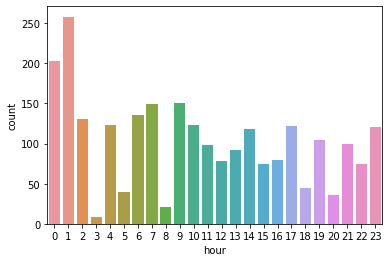

In [77]:
#Plotting counts of hour to see if some hours are more popular than others
a=sns.countplot(x='hour', data=train)
#Seems like the most rides occur between midnight and 2 am

In [82]:
#Creating function that will categorize hours with more than 150 rides as busiest, hours with approx. 100-150 rides as busy, and hours with less than 100 rides as not busy
def busy(x):
    if x['hour'] == 0 or x['hour']==1 or x['hour']==7 or x['hour']==9:
        return ('Busiest')
    if x['hour'] == 2 or x['hour']==4 or x['hour']==6 or x['hour']==10 or x['hour']==14 or x['hour']==17 or x['hour']==19 or x['hour']==22:
        return ('Busy')
    else:
        return ('Not Busy')

In [79]:
#applying function to dataframe
train['busyness'] = train.apply(lambda x: busy(x), axis=1)

ValueError: Could not interpret input 'busyness'

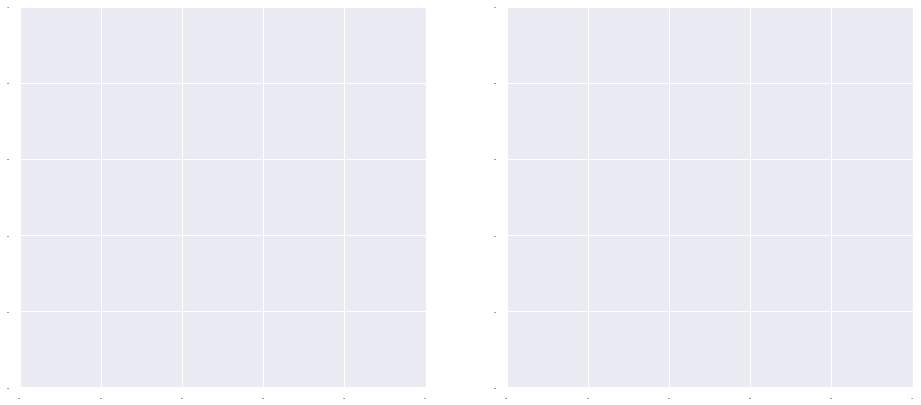

In [250]:
#Visualizing whether busier hours have higher prices
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'busyness', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'busyness', y = 'price', hue = 'cab_type')
plt.title('Price Distribution by Busyness')
#Seems not to be much of a difference in price based on busyness overall but may make a difference for uber rides

In [249]:
#Another visualization to conifirm previous conclusion
a = sns.scatterplot(data = train, x = 'hour', y = 'price', hue = 'busyness')
plt.title('Price vs Hour, by Busyness')
plt.xlabel('Hour')
plt.ylabel('Price')
#Again we can see that there is no significant difference in price by busyness of the hour

ValueError: Could not interpret value `busyness` for parameter `hue`

### Sabrina: Combining Hour and Location EDAs

In [205]:
#graphing location price by hour busyness
sns.countplot(x='location', data=train, hue='busyness')
plt.legend(title='Busyness', fontsize=11)
plt.xticks(rotation=45)
#Busy hours seem more expensive, especially in Haymarket Square

ValueError: Could not interpret input 'busyness'

### Sabrina: Day EDA

Text(0.5, 1.0, 'Price Distribution by Day')

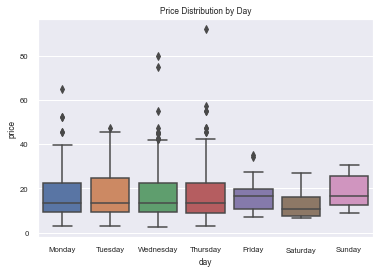

In [93]:
#Visualizing to see if price depends on day
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sns.boxplot(x='day',y='price', data=train, order=order )
plt.title('Price Distribution by Day')
#Price seems to vary by day, Friday and Sunday seem most expensive

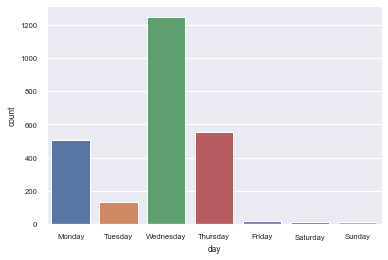

In [94]:
#Visualizing ride number per day to see if some days are busier than others
sns.set(font_scale=0.7)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
a=sns.countplot(x='day', data=train, order=order)
#Barely any rides during the weekend which is concerning

In [96]:
train.loc[train['day']=='Sunday']
#only 11 rides
#Although price varies significantly. May be helpful in overall prediction but not so much if stakeholders are looking for weekend predictions

,Unnamed: 0,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,...,wind,time_weather,hour,date,day,wind_d_strength,pressure_d_strength,humidity_d_strength,humidity_strength_3,busyness
425,3818,3.04,Uber,West End,Boston University,16.0,1.0,8b4b47cd-8398-4564-add7-9c55ef1ae144,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,3.85,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Not Busy
481,3798,2.30,Uber,Back Bay,Haymarket Square,30.5,1.0,2d61cf2b-2dbc-4c95-ae84-89a0e1ef6cb4,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,2.44,2018-12-02 19:53:05.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Busy
603,3815,3.04,Uber,West End,Boston University,9.0,1.0,4ef6a5c7-e254-41ef-a6d7-78c4e5613a97,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,3.85,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Not Busy
733,3816,3.04,Uber,West End,Boston University,25.0,1.0,6d6fe9fa-743e-4958-bcee-dd8a7d4d7a63,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,3.85,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Not Busy
864,1069,2.72,Uber,West End,Fenway,9.0,1.0,af71ac42-de43-4aa7-b742-1fdcd7f25550,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,2.47,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Busy
944,1070,1.44,Lyft,Back Bay,Fenway,27.5,1.0,fa888248-99fd-44cd-be52-b6f9114254ff,lyft_luxsuv,Lux Black XL,...,2.47,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Busy
951,2630,2.84,Lyft,West End,Fenway,16.5,1.0,4c4166b6-212b-40b8-b625-b9daf9fb7134,lyft_plus,Lyft XL,...,9.91,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,Busy
1053,2629,2.84,Lyft,West End,Fenway,19.5,1.0,1eb9ce60-4fb2-4a22-8814-4ab1cb3738c1,lyft_premier,Lux,...,9.91,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,Busy
1333,1071,1.44,Lyft,Back Bay,Fenway,16.5,1.0,ff3ee53f-5f14-4474-a057-869fa20f7ef8,lyft_lux,Lux Black,...,2.47,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,Busy
1602,2631,2.84,Lyft,West End,Fenway,26.0,1.0,685c2277-5b5d-481a-9ede-feec6c8bcbe7,lyft_lux,Lux Black,...,9.91,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,Busy


## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Michael: Base Models Development

In [8]:
#Test data mean for price variable
test.price.mean()

16.821596244131456

In [7]:
#Test data standard deviation for price variable
test.price.std()

9.862237316817094

In [3]:
#Creating linear regression model with distance as only predictor as base model
slr_model_initial = smf.ols(formula = 'price~distance', data = train).fit()
slr_model_initial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     333.2
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           5.96e-70
Time:                        04:16:25   Log-Likelihood:                -8942.7
No. Observations:                2483   AIC:                         1.789e+04
Df Residuals:                    2481   BIC:                         1.790e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2923      0.389     26.442      0.000       9.529      11.056
distance       2.9060      0.159     18.254      0.000       2.594       3.218
==============================================================================
Omnibus:                      481.603   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1140.219
Skew:                           1.075   Prob(JB):                    2.54e-248
Kurtosis:                       5.530   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
#Calculating RMSE for test data for initial linear regression model with one predictor
np.sqrt(((test.price - slr_model_initial.predict(test))**2).mean())

9.162502675127415

In [6]:
#Calculating RSE for train data for initial linear regression model with one predictor
np.sqrt(slr_model_initial.mse_resid)

8.873038155281062

In [11]:
#Creating multiple linear regression model with all ride dataset predictors as base model
mlr_model_initial = smf.ols(formula = 'price~distance+cab_type+destination+source+product_id+name', data = train).fit()
mlr_model_initial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     581.0
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:22:37   Log-Likelihood:                -6395.0
No. Observations:                2483   AIC:                         1.286e+04
Df Residuals:                    2449   BIC:                         1.306e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                           3.055e+12   4.14e+12      0.738      0.461   -5.06e+12    1.12e+13
cab_type[T.Uber]                                   -6.709e+12   9.09e+12     -0.738      0.461   -2.45e+13    1.11e+13
destination[T.Beacon Hill]                            -0.3032      0.319     -0.951      0.342      -0.928       0.322
destination[T.Boston University]                    8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.Fenway]                               8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.Financial District]                      0.1269      0.307      0.413      0.680      -0.475       0.729
destination[T.Haymarket Square]                     8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.North End]                            8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.North Station]                           0.5213      0.305      1.707      0.088      -0.078       1.120
destination[T.Northeastern University]              8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.South Station]                        8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
destination[T.Theatre District]                        0.0474      0.307      0.155      0.877      -0.554       0.649
destination[T.West End]                               -0.2009      0.318     -0.631      0.528      -0.825       0.423
source[T.Beacon Hill]                                 -1.1500      0.328     -3.504      0.000      -1.794      -0.506
source[T.Boston University]                         8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.Fenway]                                    8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.Financial District]                          -0.0524      0.332     -0.158      0.875      -0.703       0.598
source[T.Haymarket Square]                          8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.North End]                                 8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.North Station]                               -1.2469      0.321     -3.879      0.000      -1.877      -0.617
source[T.Northeastern University]                   8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.South Station]                             8.655e+10   1.17e+11      0.738      0.461   -1.43e+11    3.17e+11
source[T.Theatre District]                            -0.3737      0.328     -1.139      0.255      -1.017  

In [12]:
#Calculating RMSE for test data for initial multiple linear regression model with six predictor
np.sqrt(((test.price - mlr_model_initial.predict(test))**2).mean())

3.6270205260516555

In [13]:
#Calculating RSE for train data for initial multiple linear regression model with six predictors
np.sqrt(mlr_model_initial.mse_resid)

3.2010534406204667

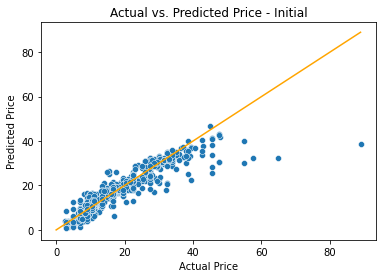

In [16]:
#Plotting predicted price against actual price
mlr_graph = sns.scatterplot(x = test.price, y = mlr_model_initial.predict(test))
mlr_graph = sns.lineplot(x = [0, test.price.max()], y = [0, test.price.max()], color = 'orange')
mlr_graph = mlr_graph.set(xlabel = 'Actual Price', ylabel = 'Predicted Price', title = 'Actual vs. Predicted Price - Initial')

The above graph of actual vs. predicted price plot shows that the plotted points don't end up seeming to follow the exact line trend of predicted price = actual price as the actual price increases.

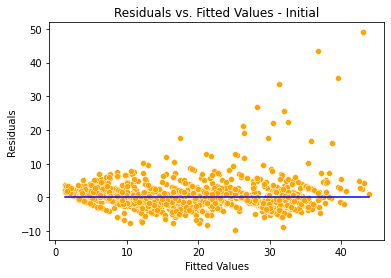

In [17]:
#Plotting residuals against fitted values to address model assumptions
mlr_residuals = sns.scatterplot(x = mlr_model_initial.fittedvalues, y=mlr_model_initial.resid,color = 'orange')
mlr_residuals = sns.lineplot(x = [mlr_model_initial.fittedvalues.min(),mlr_model_initial.fittedvalues.max()],y = [0,0],color = 'blue')
mlr_residuals = mlr_residuals.set(xlabel='Fitted Values', ylabel='Residuals', title='Residuals vs. Fitted Values - Initial')

While this base model did mostly seem to not violate the linearity assumption, there did seem to be a problematic trend as the fitted values increased that residuals tended to stray away from the line of residuals = 0 that could mean it violated the constant variance assumption. 

### Keaton: Outlier/High-Leverage/Influential Point Detection and Analysis

In [ ]:
#get studentized residuals of baseline model
out = mlr_model_initial.outlier_test()
#output number of outliers in the data
np.sum((np.abs(out.student_resid)>3))

In [ ]:
#calculate number of outliers as percent of total observations
25/train.shape[0]

In [ ]:
#get the influence of the observations
influence = mlr_model_initial.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (mlr_model_initial.df_model+1)/mlr_model_initial.nobs

In [ ]:
#calculate the high leverage threshold
high_leverage_threshold = 4*average_leverage
#output the number of high leverage points
np.sum(leverage>high_leverage_threshold)

In [18]:
mlr_model_weather = smf.ols(formula = 'price~distance+uber+temp+clouds+pressure+rain+humidity+wind+product_accessible+product_luxury+product_shared+product_standard+product_suv+product_town_car+product_xl', data = train).fit()
mlr_model_weather.summary()

PatsyError: Error evaluating factor: NameError: name 'product_xl' is not defined
    price~distance+uber+temp+clouds+pressure+rain+humidity+wind+product_accessible+product_luxury+product_shared+product_standard+product_suv+product_town_car+product_xl
                                                                                                                                                               ^^^^^^^^^^

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.